# Exploring Observation Data From Tilde, Application to envirosensor Data

## &nbsp;Table of contents
### 1. Introduction
### 2. Building a Query for a specific sensor code/stream
### 3. Building a Query without sensor code/stream
### 4. Building a Query for the latest data
### 5. Building a Query for aggregated data

## &nbsp;1. Introduction

In this tutorial we will be learning how to use Python to query the Tilde API Data Summary endpoint. To highlight different functionalities and the data available we will be using the envirosensor (Environmental Sensor) dataset. This dataset is derived from GeoNet's Low Rate Data Collection Platform (LRDCP). Tilde is the API (Application Programmatic Interface) to access envirosensor data. You do not need to know anything about APIs to use this tutorial. If you would like more info see https://tilde.geonet.org.nz/v3/api-docs/.

This tutorial assumes you have basic knowledge of Python. In this tutorial we will be building different queries to show different streams and sensor codes for different time periods. We will also generate a plot of aggregated data with a daily mean and raw observations. 

###### About GeoNet envirosensor data and the Low Rate Data Collection Platform

GeoNet currently has 15 environmental stations at various locations across the central North Island volcanoes and Mt Taranaki, and at sites near Fox Glacier in the South Island. They are used to measure various factors related to volcanic activity, and factors that influence the movement of landslides. These include measuring: fumarole temperature, lake height and temperature, spring height and temperature, rainfall, soil moisture, displacement across cracks in landslides. Most of these sites measure 2-3 of these factors. Different aspects can also be selected if there are more than one similar measure at a site, for example there is a south-vent and an east-vent aspect for fumarole temperature at one of the Tongariro sites (TO006), and soil moisture is measured by a single sesnor at eight different depths at a site at Fox Glacier. The envirosensors are part of the Low Rate Data Collection Platform (LRDCP). Tilde provides access to minimum, the maximum and the snapshot data.  

A web page providing more information on the LRDCP is in preparation.

## &nbsp;2. Building a Query for a specific sensor code/stream

###### Import required modules and set the source URL

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
source = 'https://tilde.geonet.org.nz/v3'

### Request data for a specific sensor/stream with date range, and then returning a CSV file

This query returns the observations of the specified data held in Tilde. <br>
The endpoint we are going to use is `https://tilde.geonet.org.nz/v3/data/`.

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/-`, this is fumarole-temperature data collected as a 'snapshot' using sensor 02 at the station NA002, which is near the summit of Ngauruhoe volcano
- startdate = '2022-03-01'
- enddate = '2022-03-15'

We will ask for data for 2022 March 1 to 15.

We begin by setting the URL with these new parameters.

In [3]:
url = source+'/data/envirosensor/OT001/lake-temperature/01/snapshot/-/2022-03-01/2022-03-15'

We will now query the URL and ask for a CSV format to be returned

In [4]:
r = requests.get(url, headers={'Accept':'text/csv'})
print (r)

<Response [200]>


We use `requests.get` to retrieve the data from the URL. The response status code says whether we were successful in getting the data requested and why not if we were unsuccessful:
<ul>
<li>200 -- everything went okay, and the result has been returned (if any)
<li>301 -- the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
<li>400 -- the server thinks you made a bad request. This can happen when you don't send along the right data, among other things.
<li>404 -- the resource you tried to access wasn't found on the server.
</ul>

To work with the observation data we will use python's pandas module (https://pandas.pydata.org/). We will now store the response of our request in a pandas dataframe (`df`), using `pd.read_csv`. By using `parse_dates=['time']` we can convert the 'time' to a datetime and with `index_col` we can set the time as the index of the  dataframe. More information on `pd.read_csv` can be found here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html. We need to use the `StringIO` function with the text returned from our query. By printing the beginning of the result (`df.head()`) we can also see the result of this new index column.

In [5]:
df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')
df.head()

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-03-01 00:00:00+00:00,envirosensor,OT001,lake-temperature,1,snapshot,nil,53.16,0.0,NaN
2022-03-01 00:10:00+00:00,envirosensor,OT001,lake-temperature,1,snapshot,nil,53.33,0.0,NaN
2022-03-01 00:20:00+00:00,envirosensor,OT001,lake-temperature,1,snapshot,nil,53.09,0.0,NaN
2022-03-01 00:30:00+00:00,envirosensor,OT001,lake-temperature,1,snapshot,nil,52.91,0.0,NaN
2022-03-01 00:40:00+00:00,envirosensor,OT001,lake-temperature,1,snapshot,nil,52.77,0.0,NaN


#### Data Summary
By using `df.describe` we can summarise the returned data as this feature generates descriptive statistics from dataframes. From the result we can see how many values (and errors) there are, and all of the qc values are currently undefined. By default, we also to get to see the mean, standard deviation, minimum, maximum, and some percentile values.

In [6]:
df.describe()

,sensorCode,value,error,qualityControl
count,2160.0,2160.000000,2160.0,0.0
mean,1.0,47.268782,0.0,NaN
std,0.0,2.106722,0.0,NaN
min,1.0,43.370000,0.0,NaN
25%,1.0,45.457500,0.0,NaN
50%,1.0,47.010000,0.0,NaN
75%,1.0,48.280000,0.0,NaN
max,1.0,53.720000,0.0,NaN


#### Basic Data Plot
By using the `value` column from our dataframe we are able to plot the data against time. For this plot we will use dots and a line joining the data, so our sampling is obvious. You'll notice that the observations seems quite 'spiky'. This is because the values are measured to one decimal place, and the range of observed values (in this case fumarole-temperature) is quite small over the short period we are examining. 

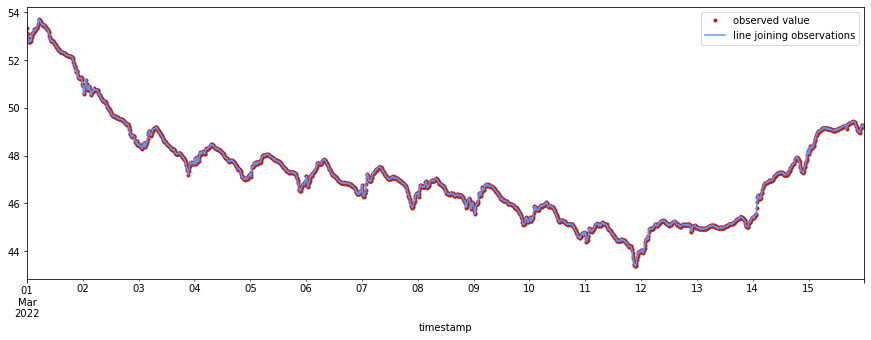

In [7]:
fig,ax = plt.subplots(figsize=(15,5))
df['value'].plot(ax=ax, color='firebrick', marker='.', linestyle='None', label='observed value')
df['value'].plot(ax=ax, color='cornflowerblue', label='line joining observations')
    
plt.legend(loc='best')

## &nbsp;3. Building a Query without sensor code/stream

Tilde can also provide all of the available data for a date range without having to specify the sensor code and stream parameters.

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/-/-/-`
- startdate = '2022-03-01'
- enddate = '2022-03-01'

Using the above parameters will return data from all sensor codes (for NA002 there are sensor codes 02, 03 for these dates) and all data methods (max, min, snapshot). These will be returned in CSV format. 
The available location codes for each station are available in GeoNet's github repository (https://github.com/GeoNet/delta/blob/main/network/sites.csv). Sensor codes will be provided in the `Location` column (and for envirosensor those will be 01, 02, 03, etc for as many sensors as are installed). <br>

We will begin by following similar steps to Section 2 and changing the URL with the new parameters, quering the URL and asking for the CSV format to be returned.

In [8]:
url = source+'/data/envirosensor/NA002/fumarole-temperature/-/-/-/2022-03-01/2022-03-01'

r = requests.get(url, headers={'Accept':'text/csv'})

df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

#####  Sorted by method not date
By printing the top 2 rows of the dataframe (`df.head(2)`) and the bottom 2 rows (`df.tail(2)`), we can see that the data returned are sorted alphabetically by method (max/min/snapshot) and not by date. This is nothing we have done, it is just the way the API returns the data.

In [9]:
df.head(2)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-03-01 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,max,nil,82.1,0.0,NaN
2022-03-01 00:10:00+00:00,envirosensor,NA002,fumarole-temperature,2,max,nil,82.0,0.0,NaN


In [10]:
df.tail(2)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-03-01 23:40:00+00:00,envirosensor,NA002,fumarole-temperature,3,snapshot,nil,82.5,0.0,NaN
2022-03-01 23:50:00+00:00,envirosensor,NA002,fumarole-temperature,3,snapshot,nil,82.6,0.0,NaN


#### Select one sensor and separate max, min, and snapshot data into different dataframes 
Chose just one of the sensors, 02, and separate data into three distinct dataframes using the `method` column so we can then separate out the max, min, and snapshot values.

In [11]:
dfmax = df[(df['method']=='max') & (df['sensorCode']==2)]
dfmin = df[(df['method']=='min') & (df['sensorCode']==2)]
dfsnap = df[(df['method']=='snapshot') & (df['sensorCode']==2)]

#### Basic visualization

As the three datatypes (max, min, and snapshot) have now been separated, we can plot them with different colours. Under normal circumstances, the `snapshot` data will most likely be the only stream used, but `min` and `max` give a useful measure of variability of the observation, if that is imprtant to you.

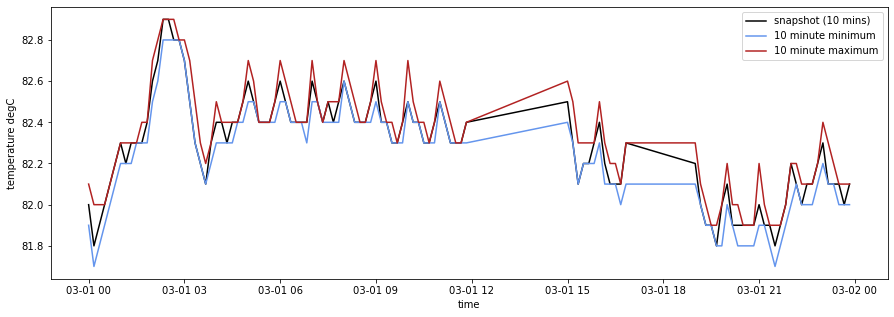

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(dfsnap['value'], color='black', label='snapshot (10 mins)')
ax.plot(dfmin['value'], color='cornflowerblue', label='10 minute minimum')
ax.plot(dfmax['value'], color='firebrick', label='10 minute maximum')
    
ax.set_ylabel('temperature degC')
ax.set_xlabel('time')

plt.legend(loc='best')

## &nbsp;4. Building a Query for the latest data

This query returns the observations of the specified data held in Tilde. The query is `https://tilde.geonet.org.nz/v3/data/`.

The minimum required parameters are:
- domain = `envirosensor`
- key = `NA002/fumarole-temperature/02/snapshot/-`,
- startdate = 'latest'
- enddate = '7d'

We will begin by following similar steps that we have followed previously by, changing the URL with the new parameters, quering the URL and asking for the CSV format to be returned. This request will return data in a CSV format for the last 7 days.

In [13]:
url = source+'/data/envirosensor/NA002/fumarole-temperature/02/snapshot/-/latest/7d'

r = requests.get(url, headers={'Accept':'text/csv'})

df = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

We can see in the tail of the dataframe that we have the `latest` or most recent data.

In [14]:
df.tail()

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2023-02-01 02:10:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,73.92,0.0,NaN
2023-02-01 02:20:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,74.01,0.0,NaN
2023-02-01 02:30:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,74.09,0.0,NaN
2023-02-01 02:40:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,74.13,0.0,NaN
2023-02-01 02:50:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,74.23,0.0,NaN


#### Data volume
<br>
By using `len(df.index)` we can easily generate a row count of the dataframe. This could be useful to see how many values we received in a certain period of time for a station. This is likely to be quite predictable, but may vary from what we expect if we haven't been able to retrieve some data from the station. In this case, for the last 7 days we should expect 7 * 144 = 1008 observations. Site NA002 uses the cell phone network for communications, and the cellular signal at the site, at the summitt of Ngauruhoe, isn't always completely reliable, so 1008 observations is not always achieved. We do have a data "backfill" process to try to retrieve any missing data, but that may not have run when a query is made.

In [15]:
len(df.index)

978

## &nbsp;5. Building a query for aggregated data
<br>
When requesting a large amount of data over a long time period, the query can be optimized for quick visualisation using the optional `aggregationPeriod`and `aggregationFunction` parameters. We will use our initial query example above, with a 15 day range (2022-03-01 to 2022-03-15) and use an aggregation period of 1 day to return a daily mean of the values each day. Notice that, due to the aggregation, our dataframe's index column has time values 00:00:00.

In [16]:
url = source+'/data/envirosensor/NA002/fumarole-temperature/02/snapshot/-/2022-03-01/2022-03-15?aggregationPeriod=1d&aggregationFunction=mean'

r = requests.get(url, headers={'Accept':'text/csv'})
dfmean = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')
dfmean.tail(5)

,domain,station,name,sensorCode,method,aspect,value,error,qualityControl
timestamp,,,,,,,,,
2022-03-11 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,81.997222,0.0,NaN
2022-03-12 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,82.394444,0.0,NaN
2022-03-13 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,82.186806,0.0,NaN
2022-03-14 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,82.326389,0.0,NaN
2022-03-15 00:00:00+00:00,envirosensor,NA002,fumarole-temperature,2,snapshot,nil,82.284167,0.0,NaN


In [17]:
url = source+'/data/envirosensor/NA002/fumarole-temperature/02/snapshot/-/2022-03-01/2022-03-15'

r = requests.get(url, headers={'Accept':'text/csv'})
dfraw = pd.read_csv(StringIO(r.text),parse_dates=['timestamp'], index_col='timestamp')

#### Visualize the data
<br>
We'll show the daily mean observaton together with the raw observations. That way we can see the effect of aggregation. Remember, the time of the mean for each days is 00:00:00, so it plots at the start of each day.

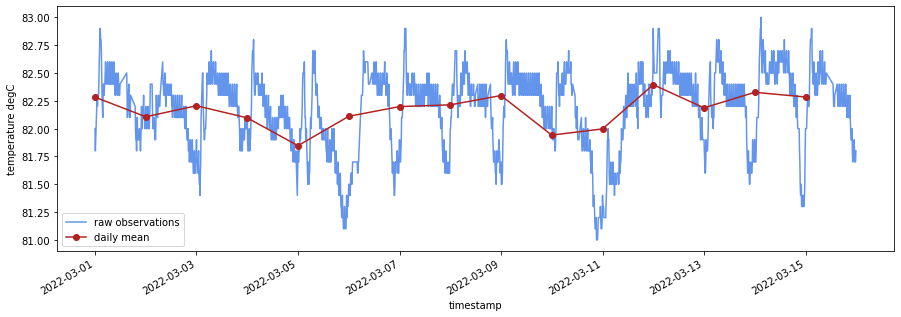

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
dfraw['value'].plot(ax=ax, color='cornflowerblue', label='raw observations')
dfmean['value'].plot(ax=ax, color='firebrick', marker='o', label='daily mean')
  
ax.set_ylabel('temperature degC')

plt.legend(loc='best')